## Lesson 3: Email Assistant with Semantic Memory

We previously built an email assistant that:
- Classifies incoming messages (respond, ignore, notify)
- Drafts responses
- Schedules meetings

Now, we'll add memory. 

We'll give the assistant the ability to remember details from previous emails. 

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Access <code>requirements.txt</code> , notebooks and other files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

<p> 📒 &nbsp; For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>

</div>

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their dynamic, probabilistic nature. Don't be surprised if your results differ from those shown in the video.</p>

## Load API tokens for our 3rd party APIs

In [195]:
import os
import time
from datetime import datetime
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from dotenv import load_dotenv
_ = load_dotenv()

## Repeat setup from previous lesson

In [196]:
profile = {
    "name": "John",
    "full_name": "John Doe",
    "user_profile_background": "Senior software engineer leading a team of 5 developers",
}

In [197]:
prompt_instructions = {
    "triage_rules": {
        "ignore": "Marketing newsletters, spam emails, mass company announcements",
        "notify": "Team member out sick, build system notifications, project status updates",
        "respond": "Direct questions from team members, meeting requests, critical bug reports",
    },
    "agent_instructions": "Use the tsk and memory realated tools when appropriate to help manage John's tasks efficiently."
}

In [198]:
email = {
    "from": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "body": """
Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

In [199]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain.chat_models import init_chat_model

In [200]:
openai_api_key = os.getenv("OPENAI_API_KEY")

from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-4o-mini")

In [201]:
class Router(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )

In [202]:
llm_router = llm.with_structured_output(Router)

In [203]:
from prompts import triage_system_prompt, triage_user_prompt

In [204]:
from langchain_core.tools import tool

In [205]:
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}'"


In [206]:
@tool
def schedule_meeting(
    attendees: list[str], 
    subject: str, 
    duration_minutes: int, 
    preferred_day: str
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees"


In [207]:
@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

## Define tools for managing memory

In [208]:
from langgraph.store.memory import InMemoryStore

In [209]:
store = InMemoryStore(
    index={"embed": "openai:text-embedding-3-small"}
)

In [210]:
from langmem import create_manage_memory_tool, create_search_memory_tool

In [211]:
manage_memory_tool = create_manage_memory_tool(
    namespace=(
        "email_assistant", 
        "{langgraph_user_id}",
        "collection"
    )
)
search_memory_tool = create_search_memory_tool(
    namespace=(
        "email_assistant",
        "{langgraph_user_id}",
        "collection"
    )
)

In [212]:
print(manage_memory_tool.name)

manage_memory


In [213]:
print(manage_memory_tool.description)

Create, update, or delete a memory to persist across conversations.
Include the MEMORY ID when updating or deleting a MEMORY. Omit when creating a new MEMORY - it will be created for you.
Proactively call this tool when you:

1. Identify a new USER preference.
2. Receive an explicit USER request to remember something or otherwise alter your behavior.
3. Are working and want to record important context.
4. Identify that an existing MEMORY is incorrect or outdated.


In [214]:
manage_memory_tool.args

{'content': {'anyOf': [{'type': 'string'}, {'type': 'null'}],
  'default': None,
  'title': 'Content'},
 'action': {'default': 'create',
  'enum': ['create', 'update', 'delete'],
  'title': 'Action',
  'type': 'string'},
 'id': {'anyOf': [{'format': 'uuid', 'type': 'string'}, {'type': 'null'}],
  'default': None,
  'title': 'Id'}}

In [215]:
search_memory_tool.name

'search_memory'

In [216]:
search_memory_tool.description

'Search your long-term memories for information relevant to your current context.'

In [217]:
search_memory_tool.args

{'query': {'title': 'Query', 'type': 'string'},
 'limit': {'default': 10, 'title': 'Limit', 'type': 'integer'},
 'offset': {'default': 0, 'title': 'Offset', 'type': 'integer'},
 'filter': {'anyOf': [{'additionalProperties': True, 'type': 'object'},
   {'type': 'null'}],
  'default': None,
  'title': 'Filter'}}

In [218]:
agent_system_prompt_memory = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
4. manage_memory - Store any relevant information about contacts, actions, discussion, etc. in memory for future reference
5. search_memory - Search for any relevant information that may have been stored in memory
</ Tools >

< Instructions >
{instructions}
</ Instructions >
"""

In [219]:
def create_prompt(state):
    return [
        {
            "role": "system", 
            "content": agent_system_prompt_memory.format(
                instructions=prompt_instructions["agent_instructions"], 
                **profile
            )
        }
    ] + state['messages']

In [220]:
from langgraph.prebuilt import create_react_agent

In [221]:
tools= [
    write_email, 
    schedule_meeting,
    check_calendar_availability,
    manage_memory_tool,
    search_memory_tool
]
response_agent = create_react_agent(
    llm,
    tools=tools,
    prompt=create_prompt,
    # Use this to ensure the store is passed to the agent 
    store=store
)

In [222]:
config = {"configurable": {"langgraph_user_id": "lance"}}

In [223]:
response = response_agent.invoke(
    {"messages": [{"role": "user", "content": "Jim is my friend"}]},
    config=config
)

In [224]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Jim is my friend
================================== Ai Message ==================================
Tool Calls:
  manage_memory (call_fVaAHQAWDlNRYiyQLpUnhNXy)
 Call ID: call_fVaAHQAWDlNRYiyQLpUnhNXy
  Args:
    content: Jim is John Doe's friend.
    action: create
================================= Tool Message =================================
Name: manage_memory

created memory 47a86709-900a-4cfe-aa83-08e35b36ea23
================================== Ai Message ==================================

I've noted that Jim is your friend. Let me know if you'd like to remember anything else or if there's anything I can assist you with regarding Jim!


In [225]:
response = response_agent.invoke(
    {"messages": [{"role": "user", "content": "who is jim?"}]},
    config=config
)

In [226]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

who is jim?
================================== Ai Message ==================================
Tool Calls:
  search_memory (call_klsmHi5DGxMidR3kLTAsxKCJ)
 Call ID: call_klsmHi5DGxMidR3kLTAsxKCJ
  Args:
    query: jim
================================= Tool Message =================================
Name: search_memory

[{"namespace":["email_assistant","lance","collection"],"key":"47a86709-900a-4cfe-aa83-08e35b36ea23","value":{"content":"Jim is John Doe's friend."},"created_at":"2025-07-03T19:30:03.924446+00:00","updated_at":"2025-07-03T19:30:03.924452+00:00","score":0.5012417803345929}]
================================== Ai Message ==================================

Jim is John Doe's friend. If you need more information about him or have specific inquiries, feel free to ask!


In [227]:
store.list_namespaces()

[('email_assistant', 'lance', 'collection')]

In [228]:
store.search(('email_assistant', 'lance', 'collection'))

[Item(namespace=['email_assistant', 'lance', 'collection'], key='47a86709-900a-4cfe-aa83-08e35b36ea23', value={'content': "Jim is John Doe's friend."}, created_at='2025-07-03T19:30:03.924446+00:00', updated_at='2025-07-03T19:30:03.924452+00:00', score=None)]

In [229]:
store.search(('email_assistant', 'lance', 'collection'), query="jim")

[Item(namespace=['email_assistant', 'lance', 'collection'], key='47a86709-900a-4cfe-aa83-08e35b36ea23', value={'content': "Jim is John Doe's friend."}, created_at='2025-07-03T19:30:03.924446+00:00', updated_at='2025-07-03T19:30:03.924452+00:00', score=0.5012626576504683)]

## Create the rest of the agent

In [230]:
from langgraph.graph import add_messages

class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

In [231]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing import Literal
from IPython.display import Image, display

In [232]:
def triage_router(state: State) -> Command[
    Literal["response_agent", "__end__"]
]:
    author = state['email_input']['author']
    to = state['email_input']['to']
    subject = state['email_input']['subject']
    email_thread = state['email_input']['email_thread']

    system_prompt = triage_system_prompt.format(
        full_name=profile["full_name"],
        name=profile["name"],
        user_profile_background=profile["user_profile_background"],
        triage_no=prompt_instructions["triage_rules"]["ignore"],
        triage_notify=prompt_instructions["triage_rules"]["notify"],
        triage_email=prompt_instructions["triage_rules"]["respond"],
        examples=None
    )
    user_prompt = triage_user_prompt.format(
        author=author, 
        to=to, 
        subject=subject, 
        email_thread=email_thread
    )
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email {state['email_input']}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        update = None
        goto = END
    elif result.classification == "notify":
        # If real life, this would do something else
        print("🔔 Classification: NOTIFY - This email contains important information")
        update = None
        goto = END
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    return Command(goto=goto, update=update)

## Create email agent

In [233]:
email_agent = StateGraph(State)
email_agent = email_agent.add_node(triage_router)
email_agent = email_agent.add_node("response_agent", response_agent)
email_agent = email_agent.add_edge(START, "triage_router")
email_agent = email_agent.compile(store=store)

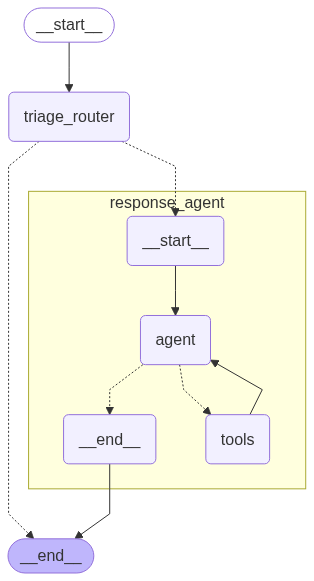

In [234]:
display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))

In [235]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

In [236]:
response = email_agent.invoke(
    {"email_input": email_input},
    config=config
)

📧 Classification: RESPOND - This email requires a response


In [237]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi John,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}
================================== Ai Message ==================================
Tool Calls:
  write_email (call_hnJcvFqUNRvSpyf234c2xyOY)
 Call ID: call_hnJcvFqUNRvSpyf234c2xyOY
  Args:
    to: Alice Smith <alice.smith@company.com>
    subject: Re: Quick question about API documentation
    content: Hi Alice,

Thank you for bringing this to my attention. I'll look into the missing endpoints for the new authenticat

## Try a follow-up email

In [238]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Follow up",
    "email_thread": """Hi John,

Any update on my previous ask?""",
}

In [239]:
response = email_agent.invoke({"email_input": email_input}, config=config)

📧 Classification: RESPOND - This email requires a response


In [240]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Follow up', 'email_thread': 'Hi John,\n\nAny update on my previous ask?'}
================================== Ai Message ==================================
Tool Calls:
  write_email (call_67TCa8yBwojL4AEExWWXwhgG)
 Call ID: call_67TCa8yBwojL4AEExWWXwhgG
  Args:
    to: Alice Smith <alice.smith@company.com>
    subject: Re: Follow up
    content: Hi Alice,

Thank you for your patience. I am currently working on your request and will provide you with an update shortly. 

Best regards,
John
================================= Tool Message =================================
Name: write_email

Email sent to Alice Smith <alice.smith@company.com> with subject 'Re: Follow up'
================================== Ai Message ==================================

I've responded to Alice Smith's email